In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
import gym
import torch
from stable_baselines3.common.callbacks import BaseCallback
import os

In [40]:
class GradientClippingCallback(BaseCallback):
    def __init__(self, clip_value=0.5, verbose=0):
        super(GradientClippingCallback, self).__init__(verbose)
        self.clip_value = clip_value

    def _on_step(self):
        torch.nn.utils.clip_grad_norm_(self.model.policy.parameters(), self.clip_value)
        return True

In [41]:
def evaluate_sensitivity(model, environment, feature_indices):
    original_state = environment.reset()
    print("Original state shape:", original_state.shape)
    sensitivities = []
    for idx in feature_indices:
        if idx >= original_state.shape[0]:
            print(f"Index {idx} is out of bounds for the state with shape {original_state.shape}")
            continue
        perturbed_state = np.copy(original_state)
        perturbation = 0.01 * (np.max(original_state) - np.min(original_state))
        perturbed_state[idx] += perturbation
        action, _states = model.predict(original_state, deterministic=True)
        perturbed_action, _ = model.predict(perturbed_state, deterministic=True)
        sensitivity = np.abs(action - perturbed_action)
        sensitivities.append(sensitivity)
    return sensitivities

In [42]:
class TransferEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, data):
        super(TransferEnv, self).__init__()
        self.data = data
        self.action_space = gym.spaces.Discrete(len(data['team'].unique()))
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),), dtype=np.float32)
        self.state = self.reset()

    def validate_observations(self, obs):
        if np.isnan(obs).any():
            print("NaN detected in observations")
            obs = np.nan_to_num(obs)
        return obs

    def reset(self):
        self.current_step = 0
        obs = self.data.iloc[self.current_step].values
        return self.validate_observations(obs)

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= len(self.data)
        reward = self.calculate_reward(action)
        if not done:
            next_state = self.data.iloc[self.current_step].values
        else:
            next_state = np.zeros_like(self.data.iloc[0].values)
        return self.validate_observations(next_state), reward, done, {}

    def calculate_reward(self, action):
        if self.current_step == 0:
            return 0
        else:
            previous_value = self.data.iloc[self.current_step - 1]['marketValue']
            current_value = self.data.iloc[self.current_step]['marketValue']
            reward = current_value - previous_value
            return reward

    def render(self, mode='human', close=False):
        pass

In [43]:
script_dir = os.path.abspath(os.getcwd())
print(script_dir)
project_dir = os.path.abspath(os.path.join(script_dir, os.pardir, os.pardir))
print(project_dir)

C:\Users\Klaudia\PycharmProjects\TalentFinder\ml\regresion
C:\Users\Klaudia\PycharmProjects\TalentFinder


In [44]:
def convert_season(season):
    start, end = season.split('/')
    if int(start) >= 25:
        start = '19' + start
    else:
        start = '20' + start
    if int(end) >= 25:
        end = '19' + end
    else:
        end = '20' + end
    return f"{start}/{end}"

def assign_season(date):
    if date.month < 8:
        return f"{date.year-1}/{date.year}"
    else:
        return f"{date.year}/{date.year+1}"

def generate_value_season(df_player_values):
    df_player_values['date'] = pd.to_datetime(df_player_values['date'], format='%d.%m.%Y', errors='coerce')
    df_player_values['season'] = df_player_values['date'].apply(assign_season)
    return df_player_values

def load_data():
    dtype_dict = {
        'column_3': str,
        'column_4': str,
        'column_5': str
    }
    df_player_seasons = pd.read_csv(os.path.join(project_dir, 'data', 'transfermarkt', 'player_seasons.csv'))
    df_player_values = pd.read_csv(os.path.join(project_dir, 'data', 'transfermarkt','player_value.csv'))
    df_player_flags = pd.read_csv(os.path.join(project_dir, 'data', 'flags','player_flags_FINAL.csv'), low_memory=False, dtype=dtype_dict)
    df_player_transfers = pd.read_csv(os.path.join(project_dir, 'data', 'transfermarkt','transfers.csv'),dtype={'transferType': str})
    df_player_players = pd.read_csv(os.path.join(project_dir, 'data', 'transfermarkt','players.csv'))
    return df_player_seasons, df_player_values, df_player_flags, df_player_transfers, df_player_players


In [45]:
df_player_seasons, df_player_values, df_player_flags, df_player_transfers, df_player_players = load_data()
df_player_values = generate_value_season(df_player_values)
df_player_transfers['season'] = df_player_transfers['season'].apply(convert_season)
result = pd.merge(df_player_flags, df_player_players, on='id')
result = pd.merge(result, df_player_values, on=['id', 'season'])
result = pd.merge(result, df_player_transfers, on=['id', 'season'])
label_encoders = {}

In [46]:
file = pd.read_csv('../../data/transfermarkt/elo_combined.csv').drop(columns=['elo_ranking_club']).rename(columns={"club": "team"})
manual_elo_values = {
    'Legia Warszawa': 2057.30,
    'Rakow Czestochowa': 2056.73,
    'Lech Poznan': 2028.27,
    'Jagiellonia Bialystok': 2010.47,
    'Pogon Szczecin': 1979.33,
    'Slask Wroclaw': 1936.03,
    'Piast Gliwice': 1934.58,
    'Cracovia Krakow': 1908.82,
    'Zaglebie Lubin': 1898.70,
    'Gornik Zabrze': 1891.41,
    'Korona Kielce': 1886.56,
    'Radomiak Radom': 1852.95,
    'Widzew Lodz': 1851.43,
    'Ruch Chorzow': 1829.66,
    'Warta Poznan': 1813.30,
    'Puszcza Niepolomice': 1804.84,
    'Stal Mielec': 1764.82,
    'LKS Lodz': 1729.92,
    'Arka Gdynia': 1874.70,
    'Lechia Gdansk': 1836.87,
    'Wisla Krakow': 1834.11,
    'GKS Katowice': 1785.84,
    'Wisla Plock': 1769.47,
    'Motor Lublin': 1766.02,
    'GKS Tychy': 1737.78,
    'Miedz Legnica': 1734.90,
    'LKS Nieciecza': 1722.74,
    'Gornik Leczna': 1696.46,
    'Odra Opole': 1691.37,
    'Polonia Warszawa': 1652.76,
    'Znicz Pruszkow': 1649.86,
    'Resovia Rzeszow': 1646.33,
    'Podbeskidzie Bielsko Biala': 1637.50,
    'Chrobry Glogow': 1636.25,
    'Stal Rzeszow': 1606.55,
    'Zaglebie Sosnowiec': 1572.21,
    'Pogon Siedlce': 1628.91,
    'Kotwica Kolobrzeg': 1618.69,
    'Stal Stalowa Wola': 1613.80,
    'KKS 1925 Kalisz': 1587.47,
    'Olimpia Grudziadz': 1578.32,
    'Chojniczanka Chojnice': 1573.93,
    'Hutnik Krakow': 1566.19,
    'SKRA Czestochowa': 1565.43,
    'Polonia Bytom': 1561.88,
    'Wisla Pulawy': 1548.34,
    'Olimpia Elblag': 1541.09,
    'Stomil Olsztyn': 1511.45,
    'GKS Jastrzebie': 1509.57,
    'Lech Poznan II': 1505.25,
    'Sandecja Nowy Sacz': 1501.80,
    'Lks Lodz II': 1493.72,
    'Zaglebie Lubin II': 1493.26,
    'Radunia Stezyca': 1489.67
}

In [47]:
for club, elo in manual_elo_values.items():
    file.loc[file['team'] == club, 'elo'] = elo
result = pd.merge(result, file, on=['team'])

In [48]:
for column in ['season', 'team', 'RED_CARD_PLAYER', 'VALUE_FLAG', 'ZERO_EXP', 'ALWAYS_ON_BENCH', 'PROGRESS_SINCE_NEW_TEAM', 'SAME_RESULTS_FOR_LONG_TIME', 'YELLOW_CARD_PLAYER', 'place_of_birth', 'birth_date', 'nationality', 'position', 'manager', 'club', 'fee', 'clubName1', 'clubName2']:
    le = LabelEncoder()
    result[column] = le.fit_transform(result[column])
    label_encoders[column] = le
result = result.sort_values(by=['id', 'season'])

In [49]:
result['previous_market_value'] = result.groupby('id')['marketValue'].shift(1)
result['previous_market_value'] = result['previous_market_value'].fillna(result['marketValue'])

target = result['marketValue']
result['height'] = result['height'].fillna(1.80)
features = result.drop(columns=['marketValue','slug', 'name', 'date_x', 'date_y','place_of_birth', 'manager','clubName1', 'clubName2','value', 'club'])

unique_ids = result['id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42)

train_data = result[result['id'].isin(train_ids)]
test_data = result[result['id'].isin(test_ids)]

In [50]:
X_train = train_data.drop(columns=['marketValue','slug', 'name', 'date_x', 'date_y','place_of_birth', 'manager','clubName1', 'clubName2', 'value', 'club'])
y_train = train_data['marketValue']
X_test = test_data.drop(columns=['marketValue','slug', 'name', 'date_x', 'date_y','place_of_birth', 'manager','clubName1', 'clubName2', 'value', 'club'])
y_test = test_data['marketValue']

le_team = LabelEncoder()
result['team'] = le_team.fit_transform(result['team'])
X_train['team'] = le_team.transform(X_train['team'])
X_test['team'] = le_team.transform(X_test['team'])

X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

X_train = X_train.dropna(axis=1, how='any')
X_test = X_test.dropna(axis=1, how='any')

In [51]:
data_without_id = result.drop(columns=['id', 'season'])
data_description = data_without_id.describe()
print("Statystyki opisowe dla zbioru danych:")
print(data_description)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

Statystyki opisowe dla zbioru danych:
               team  RED_CARD_PLAYER  YELLOW_CARD_PLAYER    VALUE_FLAG  \
count  96094.000000     96094.000000        96094.000000  96094.000000   
mean    1439.249547         0.971164            0.813079      2.174048   
min        0.000000         0.000000            0.000000      0.000000   
25%      831.000000         1.000000            1.000000      1.000000   
50%     1373.000000         1.000000            1.000000      3.000000   
75%     2151.000000         1.000000            1.000000      3.000000   
max     2833.000000         1.000000            1.000000      3.000000   
std      802.429989         0.167347            0.389850      1.199567   

           ZERO_EXP  ALWAYS_ON_BENCH  PROGRESS_SINCE_NEW_TEAM  \
count  96094.000000     96094.000000              96094.00000   
mean       0.965201         0.978479                  0.75986   
min        0.000000         0.000000                  0.00000   
25%        1.000000         1.00000

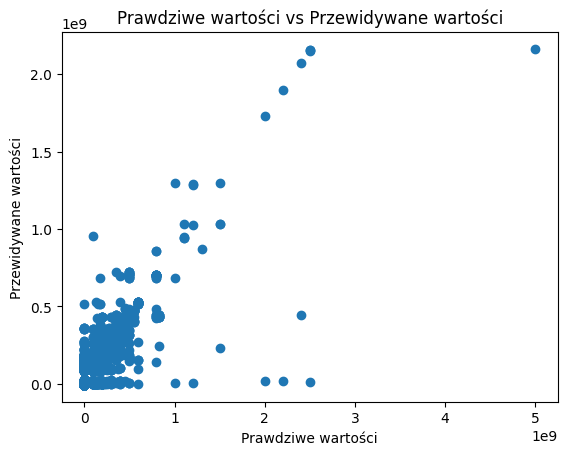

Statystyki opisowe dla residuals:
count    2.397200e+04
mean     3.328301e+05
std      5.114947e+07
min     -8.560391e+08
25%     -4.278464e+06
50%     -1.875828e+06
75%      9.564674e+04
max      2.837095e+09
Name: marketValue, dtype: float64


In [52]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions)
plt.xlabel('Prawdziwe wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Prawdziwe wartości vs Przewidywane wartości')
plt.show()

residuals = y_test - predictions
residuals_description = residuals.describe()
print("Statystyki opisowe dla residuals:")
print(residuals_description)

In [53]:
def predict_best_team_and_market_value(player_features):
    max_value = -np.inf
    best_team_index = None
    
    for team_index in range(len(le_team.classes_)):
        # Dodajemy cechę 'team'
        player_features_with_team = np.append(player_features, team_index)
        
        # Przewidujemy wartość rynkową
        predicted_value = model.predict([player_features_with_team])[0]
        
        if predicted_value > max_value:
            max_value = predicted_value
            best_team_index = team_index
            
    best_team_name = le_team.inverse_transform([best_team_index])[0]
    return best_team_name, max_value

In [54]:
player_features_example = X_test.iloc[0].drop('team')
predicted_team, predicted_value = predict_best_team_and_market_value(player_features_example)
print(f"Predicted best team: {le_team.inverse_transform([predicted_team])[0]}, Predicted market value: {predicted_value}")

C:\Users\Klaudia\PycharmProjects\pythonProject1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Klaudia\PycharmProjects\pythonProject1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Klaudia\PycharmProjects\pythonProject1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Klaudia\PycharmProjects\pythonProject1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Klaudia\PycharmProjects\pythonProject1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearReg

Predicted best team: 2833, Predicted market value: 89179072703.47723


C:\Users\Klaudia\PycharmProjects\pythonProject1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Klaudia\PycharmProjects\pythonProject1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Klaudia\PycharmProjects\pythonProject1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Klaudia\PycharmProjects\pythonProject1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Klaudia\PycharmProjects\pythonProject1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearReg